# $\textbf{Dimensionality reduction and noise removal of face images}$
# $\textbf{with Non-Negative Matrix Factorization}$

## $\textbf{TMA 4320, group 9070}$

## $\textbf{1 Introduction}$

As society is digitalizing in an ever faster manner, the quantities of available data are increasing at alarming rates. 
Motivated by this, our rapport will explore how the dimensions of certain datasets can be reduced to decrease the total amount of datapoints, and hence save space. The key to success is to create reconstruction which keeps the important features of the original dataset. To solve this task, we use a method called non-negative matrix factorization or NMF. A suitable dataset which can challenge NMF is images, and the project will be using a dataset of 10000 images of different CryptoPunk characters. 

First, the rapport will get familiar with the NMF algorithm and test it on some quite simple sets of data. We will then move on to the dataset of images where we explore dimensionality reduction. Rounding of the project, we will examine the true power of NMF, applying it to denoising of images. 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

#%pip install opencv-python # Required to import cv2 !!!
import cv2
import os
import time

## $\textbf{2 The NMF algorithm}$

Our first goal of this project is to construct a function which uses the NMF algorithm to factorize a given matrix $A$ into two matrices $W$ and $H$. The algorithm uses a multiplicative rule posed by Lee and Sung. These updates are quite simple and easy to implement, and are given below: 

$$
\begin{equation}
H_{k+1} = H_{k} \odot (W^{T}_{k} A) \oslash (W^{T}_{k}W_k H_k)
\tag{1}
\end{equation}
$$

$$
\begin{equation}
W_{k+1} = W_{k} \odot (H^{T}_{k+1} A) \oslash (W^{T}H_{k+1}H^{T}_{k+1})
\tag{2}
\end{equation}
$$

After applying these operations for a given number of iterations, $A$ can hopefully be written as $A \approx WH$. The function which runs the algorithm is named **NMF()**, and is defined later in this section. As well as taking the matrix of interest $A$ as a parameter, **NMF()** also takes in a $d$. It is this integer $d$ which determines the dimensions of the matrices $W$ and $H$. As this project will show, picking the right $d$ is crucial. Firstly, we want $W$ and $H$ combined to contain fewer datapoints than $A$. Secondly, $d$ must give the two matrices the ability to store important features of $A$.

What the NMF basically tries to do is to solve the following problem: 

$$
\begin{equation}
\min_{W,H} ||A - WH||_F
\tag{3}
\end{equation}
$$

Here $F$ is the frobenius norm, which is defined as follows: $||A|| = \sqrt{\sum_{i=1}^{m}\sum_{j=1}^{n}|a_{ij}|^2}$. Throughout the rapport, this norm will be frequently used to check if the algorithm works as expected. 


### $\textbf{Initializing W and H}$

To run the NMF algorithm, we first need to initialize $W_0$ and $H_0$. It is of great importance that the matrices $W$ and $H$ are non-negative, which means that all the elements are either positive or zero. **NMF()** initializes $W$ and $H$ with non-negative elements with the numpy function np.random.uniform(), where the random numbers are uniformly distributed. But can we now be sure that the updated $W$ or $H$ also will be non-negative matrices? 

We assume that our given dataset $A$ is non-negative, and we have already initialized $W_0$ and $H_0$ as non-negative matrices. This means that there are no negative elements in any of the matrices on the right hand side of update **(1)**. Since the operations in **(1)** is either multiplication of two floats, a sum of multiplications of two floats or division of two floats, the matrix $H_{k+1}$ cannot end up with a negative element. This implies that the same must hold for **(2)**. 

It would also be interesting to se under what circumstances $H_{k}$ is a fixed point, which means that $H_{k} = H_{k+1}$. By looking at the update given in equation **()**, one will se that it simply is $H_{k}$ multiplied elementwise with some other matrix with the same shape. If this other matrix only contains elements equal to 1.0, each element in $H_{k+1}$ will obviously keep the same value as it has only been multiplied with one. Therefore, $H_{k}$ is a fixed point if 

$$(W^{T}_{k} A) \oslash (W^{T}_{k}W_kH_k) =
\begin{bmatrix}
1 &\ldots  &1\\
\vdots &\ddots  &\vdots\\
1  &\ldots  &1\\
\end{bmatrix} $$

Lastly we will explain why it is problematic to initialize $H_0$ and $W_0$ with nothing but elements equal to zero. As the reader can see from **(1)**, one of the operations in the NMF algorithm is elementwise division. If the matrix in the denominator contains only zeros, we will encounter division by zero, and our algorithm will fail. In general, division by zero is something that we risk encountering. We avoid this by adding a small number $\delta \in [10^{-9}, 10^{-6}]$ to the denominator. By including this $\delta$, the updates now look like this:  

$$
\begin{equation}
H_{k+1} = H_{k} \odot (W^{T}_{k} A) \oslash (W^{T}_{k}W_kH_k + \delta)
\tag{4}
\end{equation}
$$

$$
\begin{equation}
W_{k+1} = W_{k} \odot (H^{T}_{k+1} A) \oslash (W^{T}H_{k+1}H^{T}_{k+1} + \delta)
\tag{5}
\end{equation}
$$



### $\textbf{The algorithm}$

In [7]:
def NMF(A, d, delta = 10**-9, maxiter = 1000, seed = 0): 
    m, n = np.shape(A)
    
    #Use seed to get coherent results
    if seed != 0:
        np.random.seed(seed)

    #initializing W and H as two non-negative matrices. 
    W = np.random.rand(m, d)
    H = np.random.rand(d, n)

    #Scale matricies
    W = W * np.sqrt(np.mean(A)/d)
    H = H * np.sqrt(np.mean(A)/d)

    #Allocate memory for array
    norm_arr = np.zeros(maxiter)
    
    for k in range(maxiter): 
        H = H * (np.transpose(W) @ A) / (np.transpose(W) @ W @ H + delta)
        W = W * (A @ np.transpose(H)) / (W @ H @ np.transpose(H) + delta)

        norm_arr[k] = np.linalg.norm(A - W@H)
    
    return W, H, norm_arr

Above the reader can see the function **NMF()**, where we have implemented the multiplicative rule given in **(1)** and **(2)**. This function also calculates the frobenius norm $||A-WH||_F$ for each iteration and returns this in an array. 

## $\textbf{3 Testing the NMF algorithm}$

The next step in this project is to verify that **NMF()** acts as it should. For this, we will look at the matrices given below: 

$$A_1 = \left[\begin{array}{cc} 1 & 0 \\ 0 & 1 \end{array}  \right] , A_2 = \left[\begin{array}{cc} 1 & 2 \\ 1 & 1 \\ 1 & 2 \end{array} \right] 
, A_3 = \left[\begin{array}{ccc} 2 & 1 & 1 \\ 2 & 1 & 1 \\ 1 & 1 & 2 \end{array} \right]
, A_4 = \left[\begin{array}{ccc} 2 & 1 & 0 \\ 1 & 2 & 3 \\ 0 & 3 & 3 \end{array} \right]$$



In [22]:
#Initializing the matrices
A_1 = np.array([[1, 0], [0, 1]], dtype = float)
A_2 = np.array([[1, 2], [1, 1], [1, 2]], dtype = float)
A_3 = np.array([[2, 1, 1], [2, 1, 1], [1, 1, 2]], dtype = float)
A_4 = np.array([[2, 1, 0], [1, 2, 3], [0, 3, 3]], dtype = float)

#function that prints the matrix
def print_matrix(A):
    m,n = np.shape(A)

    for i in range(m):
        for j in range(n):
            print("%10.3E" % A[i][j], end = "  ")
        print()

In [1]:
'''#First test with A1 and A2, d = 1

#With seed = 0
W1_nmf, H1_nmf, norm_11 = NMF(A_1, 1)
W2_nmf, H2_nmf, norm_12 = NMF(A_2, 1)

#With seed = 1
W1_nmf2, H1_nmf2, norm_21 = NMF(A_1, 1, seed = 1)
W2_nmf2, H2_nmf2, norm_22 = NMF(A_2, 1, seed = 1)
'''

'#First test with A1 and A2, d = 1\n\n#With seed = 0\nW1_nmf, H1_nmf, norm_11 = NMF(A_1, 1)\nW2_nmf, H2_nmf, norm_12 = NMF(A_2, 1)\n\n#With seed = 1\nW1_nmf2, H1_nmf2, norm_21 = NMF(A_1, 1, seed = 1)\nW2_nmf2, H2_nmf2, norm_22 = NMF(A_2, 1, seed = 1)\n'

#### $\textbf{First experiment with seed = 0}$

$W_1 = \left[\begin{array}{cc} 6.529 \cdot 10^{-2}\\ 1.317 \cdot 10^{-1} \end{array}  \right]$, 
$H_1 = \left[\begin{array}{cc} 3.021 & 6.095 \end{array}  \right]$, 
$W_1 H_1 = \left[\begin{array}{cc} 1.975 \cdot 10^{-1} & 3.979 \cdot 10^{-1}\\ 3.979\cdot10^{-1} & 8.027 \cdot 10^{-1} \end{array}  \right]$, 
$||A_1 - W_1 H_1||_F = 1.0$



$W_2 = \left[\begin{array}{cc} 7.300 \cdot 10^{-1}\\ 4.455 \cdot 10^{-1} \\ 9.213 \cdot 10^{-1} \end{array}  \right]$, 
$H_2 = \left[\begin{array}{cc} 5.107 & 2.662 \end{array}  \right]$, 
$W_2 H_2 = \left[\begin{array}{cc} 1.100 & 1.943 \\
0.6715 & 1.186 \\ 
1.100 & 1.943 \end{array}  \right]$, 
$||A_2 - W_2 H_2||_F = 0.411$

#### $\textbf{First experiment with seed = 1}$

$W_1 = \left[\begin{array}{cc} 2.949 \cdot 10^{-1}\\ 5.094 \cdot 10^{-1} \end{array}  \right]$, 
$H_1 = \left[\begin{array}{cc} 8.513 \cdot 10^{-1} & 1.470 \end{array}  \right]$, 
$W_1 H_1 = \left[\begin{array}{cc} 2.510 \cdot 10^{-1} & 4.336 \cdot 10^{-1}\\ 4.336 \cdot10^{-1} & 7.490 \cdot 10^{-1} \end{array}  \right]$, 
$||A_1 - W_1 H_1||_F = 1.0$

$W_2 = \left[\begin{array}{cc} 9.213 \cdot 10^{-1}\\ 5.623 \cdot 10^{-1} \\ 9.213 \cdot 10^{-1} \end{array}  \right]$, 
$H_2 = \left[\begin{array}{cc} 1.194 & 2.109 \end{array}  \right]$, 
$W_2 H_2 = \left[\begin{array}{cc} 1.100 & 1.943 \\
0.6715 & 1.186 \\ 
1.100 & 1.943 \end{array}  \right]$, 
$||A_2 - W_2 H_2||_F = 0.411$

Above the reader will find the result from the first experiment. It includes two runs with different seeds so that the initial matrices for the two runs contains different elements. In this way, we can examine how our initial conditions affect the results. 

From the data above, one can firstly see how the factorization fails to give good results for $A_1$ with $d=1$. It is impossible to recognize the identity matrix $I_2$ from the product $W_1 H_1$. Nevertheless the algorithm behaves as it is supposed to do, as we expect the norm of $A_1 - W_1 H_1$ to be equal to one. Secondly, from the factorization of $A_2$ one can clearly see that $W$ and $H$ are not unique. The elements of these matrices differ quite a lot across the two runs. This shows that there may be infinite possible reconstructions $WH$ which solve the problem, and that the initial conditions therefore can affect the results. However, even though the matrices are different for the two runs, we end up with the same reconstruction $WH$, at least with an accuracy of 3 decimals. The fact that the algorithm is affected by the initial conditions makes it crucial that the same seed is used to generate $W_0$ and $H_0$ in order to get coherent results.  

#### $\textbf{Second experiment with d = 2}$

To minimize $||A - WH||_F$, a natural place to start is trying to increase d. Below one can see how setting $d = 2$ drastically decreased the frobenius norm for both matrices. They are both now close to zero. Even though this is a good result, it does not really make any sense to send these matrices through the NMF algorithm with $d = 2$. The essence of this project is dimensionality reduction, but $W_1 H_1$ now contains twice as many data points as $A_1$. The same can also be said about $A_2$. Results for this experiment can be seen below.    

$W_1 = \left[\begin{array}{cc} 0.000 & 4.198 \\ 4.392 \cdot 10^{-1} & 0.000 \end{array}  \right]$, 
$H_1 = \left[\begin{array}{cc} 0.000 & 2.277 \\ 2.382 & 0.000 \end{array}  \right]$, 
$W_1 H_1 = \left[\begin{array}{cc} 1.000 & 0.000 \\ 0.000 & 1.000 \end{array}  \right]$, 
$||A_1 - W_1 H_1||_F = 6.0756 \cdot 10^{-10}$



$W_2 = \left[\begin{array}{cc} 4.850 \cdot 10^{-1} & 2.681 \cdot 10^{-1}\\
4.957 \cdot 10^{-1} & 1.047 \cdot 10^{-3}\\ 
4.850 \cdot 10^{-1} & 2.681 \cdot 10^{-1} \end{array}  \right]$,
$H_2 = \left[\begin{array}{cc} 2.017 & 2.009 \\
8.136 \cdot 10^{-2} & 3.826 \end{array}  \right]$,
$W_2 H_2 = \left[\begin{array}{cc} 1.000 & 2.000 \\
1.000 & 1.000 \\ 
1.000 & 2.000 \end{array}  \right]$,
$||A_2 - W_2 H_2||_F = 1.7509 \cdot 10^{-9}$

In [2]:
#Code which spits out the results above
'''#With seed = 0
W1_nmf, H1_nmf, norm_11 = NMF(A_1, 2)
W2_nmf, H2_nmf, norm_12 = NMF(A_2, 2)
'''

'#With seed = 0\nW1_nmf, H1_nmf, norm_11 = NMF(A_1, 2)\nW2_nmf, H2_nmf, norm_12 = NMF(A_2, 2)\n'

### $\textbf{Error and convergence}$

As explained above, we are using the Frobenius norm to measure how good the factorization of $A$ is. Attention will now be turned to $A_3$ and $A_4$, as we will examine how $||A - WH||_F$ develops throughout the iterations. However, before we run the algorithm it can be usefull to study the characteristics of the given matrices, and see if we can predict how well the reconstruction will be with different values of $d$. A natural place to start is here to figure out how much information is actually stored in the matrices. This can be indicated by calculating the rank of each matrix, which is the number of linearly independent column vectors. This can be performed by **np.linalg.matrix_rank()**: 

In [24]:
rank_A3 = np.linalg.matrix_rank(A_3)
rank_A4 = np.linalg.matrix_rank(A_4)

print(f'Rank of A3: {rank_A3}')
print(f'Rank of A4: {rank_A4}')

Rank of A3: 2
Rank of A4: 3


From the cell above, the rank of $A_3$ is $2$ and the rank of $A_4$ is $3$. This is not a surprising result. As one can see, $A_3$ has two linearly dependent row-vectors. This will result in only two nonzero eigenvalues, which implies a rank equal to $2$. Because the same information is given twice in this matrix, we can expect that $d = 2$ will work well for $A_2$. On the other hand, $A_4$ has 3 linearly independent columnvectors, and will therefore contain more information. Therefore we can assume that the error for $A_4$ will be greater for $d = 2$. 

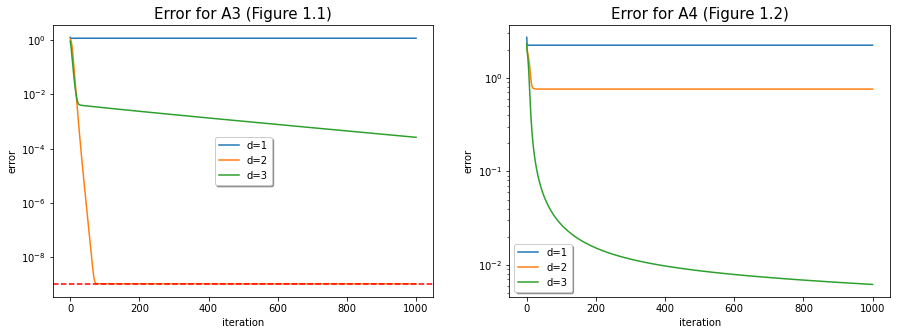

Error A3 d=1: 1.14841379830242
Error A3 d=2: 1.0596813090437913e-09
Error A3 d=3: 0.00025911915762559496
Error A4 d=1: 2.231680019120091
Error A4 d=2: 0.7577017654507554
Error A4 d=3: 0.006188230549594999


In [130]:
#Plotting the norm. 

_ , _, A3_error_d_1 = NMF(A_3,1)
_ , _, A3_error_d_2 = NMF(A_3,2)
_ , _, A3_error_d_3 = NMF(A_3,3)

iteration = np.linspace(0, 1000, len(A3_error_d_1))

_ , _, A4_error_d_1 = NMF(A_4,1)
_ , _, A4_error_d_2 = NMF(A_4,2)
_ , _, A4_error_d_3 = NMF(A_4,3)


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(iteration, A3_error_d_1, label = 'd=1')
plt.plot(iteration, A3_error_d_2, label = 'd=2')
plt.plot(iteration, A3_error_d_3, label = 'd=3')
plt.legend(fancybox = True, shadow = True)
plt.title('Error for A3 (Figure 1.1)', fontsize=15)
plt.ylabel('error')
plt.axhline(y= 10**-9, color = 'red', linestyle = 'dashed')
plt.xlabel('iteration')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(iteration, A4_error_d_1, label = 'd=1')
plt.plot(iteration, A4_error_d_2, label = 'd=2')
plt.plot(iteration, A4_error_d_3, label = 'd=3')
plt.legend(fancybox = True, shadow = True)
plt.title('Error for A4 (Figure 1.2)', fontsize=15)
plt.ylabel('error')
plt.xlabel('iteration')
plt.yscale('log')

plt.show()

print(f'Error A3 d=1: {A3_error_d_1[-1]}')
print(f'Error A3 d=2: {A3_error_d_2[-1]}')
print(f'Error A3 d=3: {A3_error_d_3[-1]}')

print(f'Error A4 d=1: {A4_error_d_1[-1]}')
print(f'Error A4 d=2: {A4_error_d_2[-1]}')
print(f'Error A4 d=3: {A4_error_d_3[-1]}')

In $\textbf{Figure 1}$ we have plotted $||A-W_k H_k||_F$ for different values of $d$ with both matrices. As one can see, the plot and our expectations are very much in tune. For $A_3$, setting $d = 2$ seems to work really well. This shows that there is a connection between the rank of the matrix and a suitable value for $d$. This is further amplified by the plot for $A_4$, where $d=2$ suddenly is not sufficient with a minima of $0.7577$. Here $d = 3$, which equals the rank of the matrix, is obviously a much better choice of $d$. Another feature with this plot is that it shows that all norms seems to be strictly decreasing. This indicates that the solution $A \approx WH$ converges towards a local minima, and satisfies the following: 

$$
\begin{equation}
||A - W_{k+1} H_{k+1}||_F ≤ ||A - W_k H_k||_F
\tag{6}
\end{equation}
$$

In addition, $\textbf{figure 1.1}$ shows how $||A_3 - HW||$ converges towards $\delta$, which is illustrated with the red dashed line. Because we are adding this $\delta$ to the multiplicative steps, this is the closest we can get to the exact solution. 

## $\textbf{4 The dataset}$

The rapport will now move away from small matrices and onto much bigger sets of data, in the form of images called CryptoPunks. The CryptoPunks dataset is made up of 10,000 CryptoPunks. The CryptoPunks collection is one of the most popular Non Fungible Tokens (NFT), a form of digital currency, which has become popular over the last few years. Each CryptoPunk is a $24 \times 24$ RGBA image. These CryptoPunks are algorithmically generated where some of the different traits, like hairstyles, glasses, cigarettes etc are shared by several different characters.

Some features are rarer than others, for example the characters with zombie and alien features. The features will always appear at the same pixels and in the same color. This should make it possible for us to decompose each image into image components. We will look at decomposition with the method NMF, which is described over. This decomposition is dependent on linearity. A character will be described by the sum of these different image components.


### $\textbf{Approach}$

To apply NMF to the images we have to reshape the image which has the shape $24 \times 24 \times 4 \times N$, to a $M \times N$ matrix. 
Since the opacity channel is only made up of ones and zeros it does not make sense to learn it by matrix factorization. Therefore we store the opacity channel separatly. The rest of the matrix is then reshaped into a $1728 \times N$ matrix. This is because we have N images and each image has $24 \times 24 \times 3 = 1728$ components. We now have the matrix in the form of a $M \times N$ matrix where $M = 1728$ and $N$ = number of images. 
Further we apply NMF, with a chosen d, to the reshaped matrix and get the $W$ and $H$ matrix.  $W$ will have the shape $M \times d$ and $H$ will have the shape $d \times N$. The information of the images is now stored in the matrix $W$, $H$ and the opacity channel.

To show the image we then have to reshape $WH$ to a $24 \times 24 \times 3 \times N$ image. Then we have to insert the opacity channel so we get a matrix on the form $24 \times 24 \times 4 \times N$ Matrix.


In [8]:
def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 10000

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

In [9]:
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None, title = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])
    
    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.suptitle(title, fontsize = 20, color = "red")
    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

In [10]:
def NMF_N_pictures(faces_choice, N = 500,d = 16):
    #making the opacity channel
    opacity_channel = faces_choice[:,:,3,:]

    #making the A matrix, so we can use NMF. the new shape is 1728 x N
    rem = faces_choice[:,:,0:3,:]
    A_faces = np.reshape(rem,(1728, N))

    #fit the NMF to this matrix
    W_faces_NMF, H_faces_NMF, error = NMF(A_faces, d)

    return W_faces_NMF, H_faces_NMF, opacity_channel, error

def reconstruct_picture(W,H, opacity ,N=500):
    A_NMF = np.reshape(W@H, (24,24,3,N))
    A_NMF = np.insert(A_NMF, 3,opacity, axis = 2)
    A_NMF[A_NMF > 1.0] = 1.0

    return A_NMF

In [113]:
np.random.seed(1)

N = 500
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces_2a = faces[:,:,:,choices]

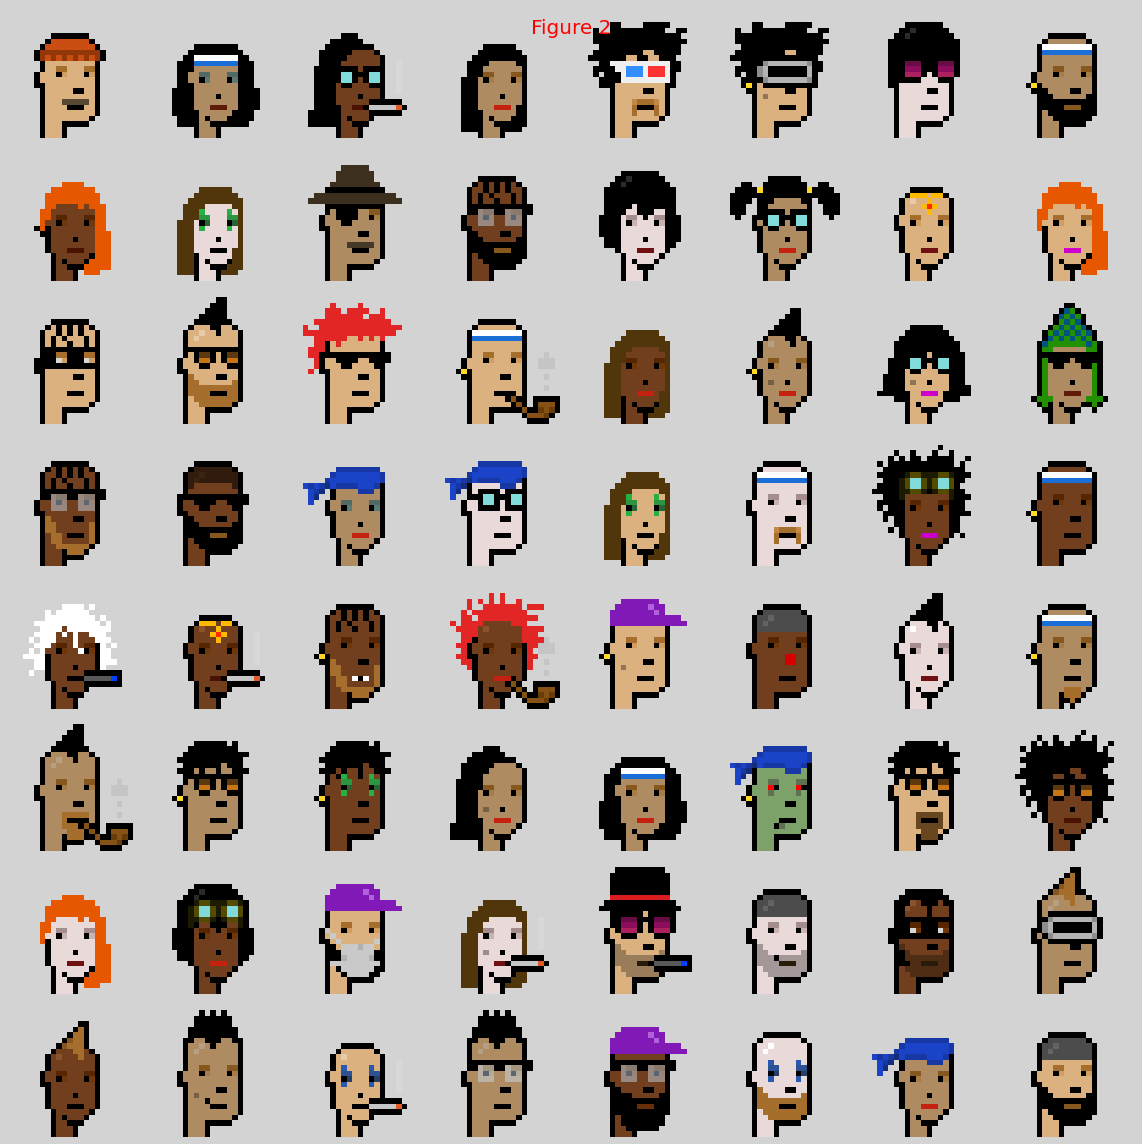

In [114]:
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png", title = "Figure 2")

In $\textbf{Figure 2}$ above we have plottet 64 random cryptopunks from the dataset. As one can see from this selection of punks, there are many traits which are common for several punks. A good example of this is the blue pirate hat, and as one can see this piece of clothing is present 4 times troughout the plot above. The orange hat is another example of a quite popular accessory. 

### $\textbf{The mean of the dataset}$

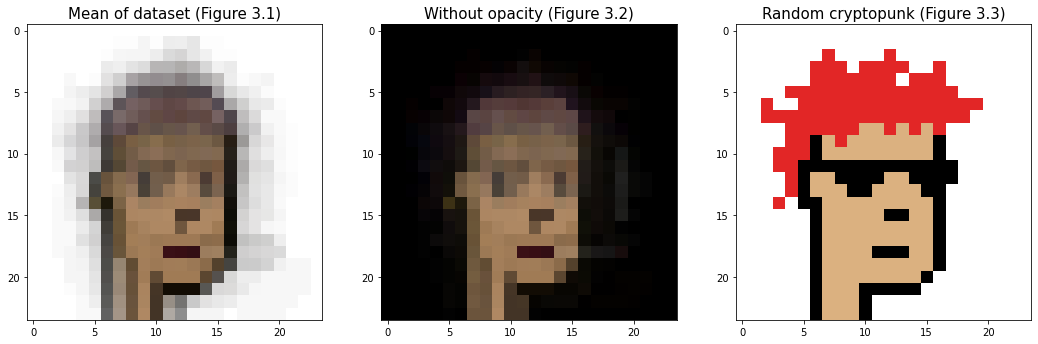

Rank of dataset: 500


In [115]:
np.random.seed(1)

N = 10000

choices = np.random.choice(faces.shape[-1],N, replace = False)
faces_choice = faces[:,:,:,choices]
opacity = faces_choice[:,:,3,:]

face_mean = np.mean(faces_choice,axis = -1)

plt.figure(figsize = (18,18))
plt.subplot(1,3,1)
plt.title("Mean of dataset (Figure 3.1)", fontsize=15)
plt.imshow(face_mean)

plt.subplot(1,3,2)
plt.title("Without opacity (Figure 3.2)", fontsize=15)
plt.imshow(face_mean[:,:,0:3])

plt.subplot(1, 3, 3)
plt.title("Random cryptopunk (Figure 3.3)", fontsize=15)
plt.imshow(faces[:, :, :, 18])

plt.show()

print(f'Rank of dataset: {np.linalg.matrix_rank(np.reshape(faces_choice[:,:,0:3,:], (1728,10000)))}')

In $\textbf{Figure 3}$ above we have plotted the mean of the three different color channels for every pixel. To the left the figure has the opacity channel, but the one in the middle does not.  
We can see that the pictures of the mean resemble a crypto punk itself. We can see that the most common features like the straight mouth and the chin are highlighted and have an opacity closer to zero. Furthermore we can see that the eyes are more or less placed around the same spot for every crypto punk.
The hair or accessories on the head are one of the components that vary the most. We can conclude with this by observing that it is the most blurry part of the picture. The only thing we can see is that many have hair or other accessories on the head.
We can also observe that all the crypto punks are centered because they all have a border with 1 in opacity. None of the crypto punks occupy these pixels.

By reshaping the entire dataset into a $1728 \times 10000$ matrix, numpy calculates the rank to be $500$. We can conclude that the rank of the matrix that contains the images is probably lower than the number of pictures. This is because the crypto punks have many similar components, or we can say just a pool of a few different components they can have. Our aim is now to capture these different features as columnvectors in $W$, such that each image can be constructed as a linear combination of the columns of $W$.  


## $\textbf{5 Applying NMF to images}$

It is now time to apply the NMF-algorithm to the dataset of CryptoPunks. For the first run $d$ is set to $64$, and the number of images $N = 500$. 

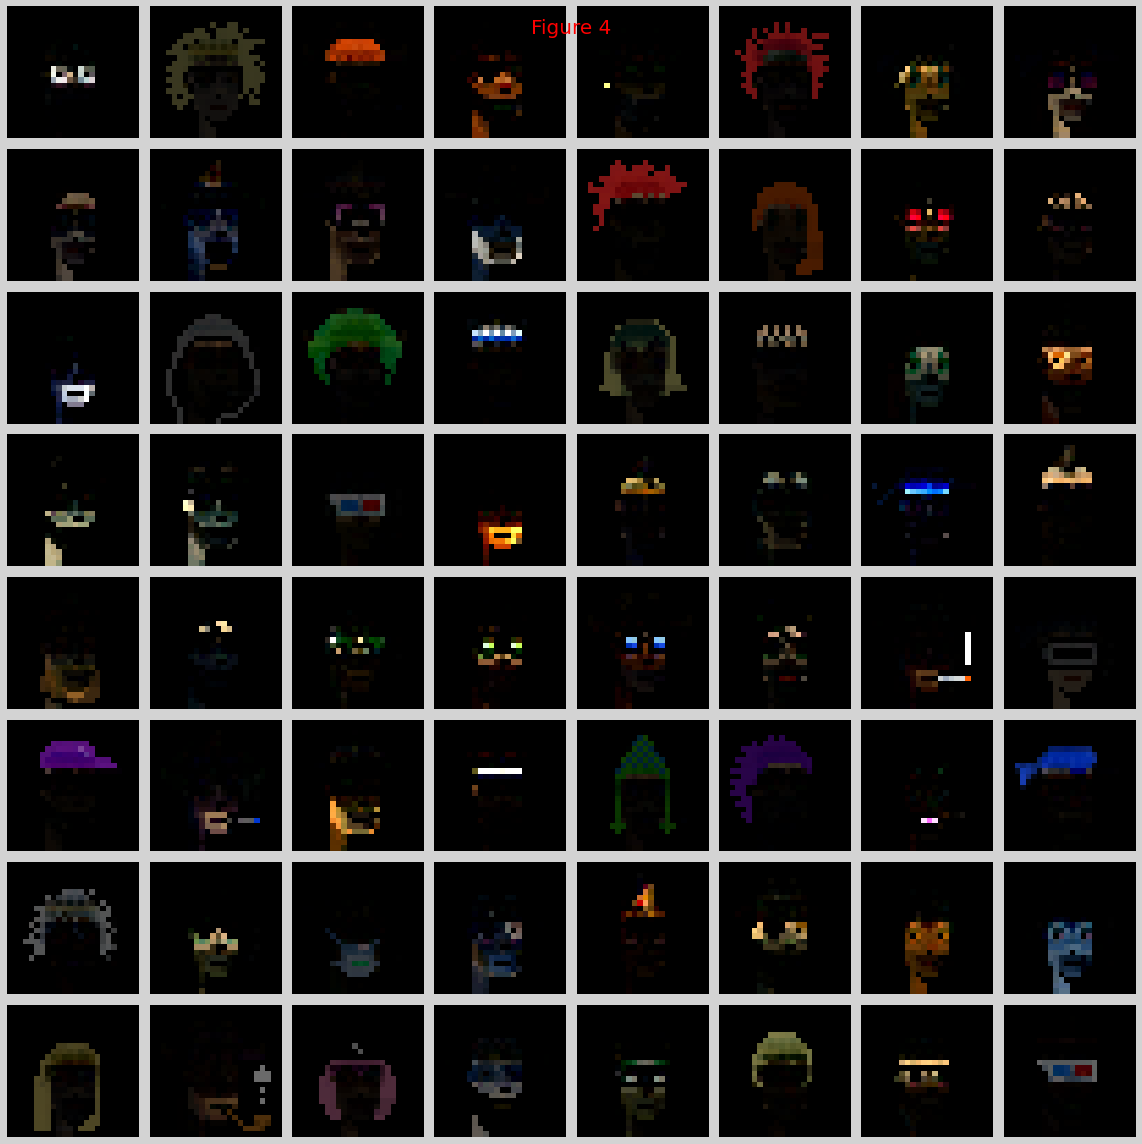

In [116]:
np.random.seed(1)

N = 500
d = 64

choices = np.random.choice(faces.shape[-1],N, replace = False)
faces_choice = faces[:,:,:,:N]

W, H, opacity, error = NMF_N_pictures(faces_choice,N,d)

W_reshaped = np.reshape(W, (24,24,3,d))
W_reshaped[W_reshaped > 1.0] = 1.0

plotimgs(W_reshaped, title = "Figure 4")

In $\textbf{figure 4}$ the columns of $W$ are interpreted as RGB images, where each column is reshaped into a $24 \times 24 \times 3$ vector. It seems like the different columns contain information about a component, for example a hat, some goggles or a part of the face. 

If we try to increase $d$, we will now have more columns to store information about different components of the dataset. As one can see from $\textbf{figure 4}$, some of the images contains more than just one component, as some of them almost captures a whole CryptoPunk. It is reasonable to expect that increasing $d$ will lead to fewer of these examples, as the columns can split the information between themselves, and hence lead to more accurate representations. The tradeoff is of course a poorer dimensional reduction.  

In $\textbf{figure 5}$ below we have plotted the columns of $W$ as images for $d = 128$. Comparing this to the former, one can now spot that each image generally contains less information. 

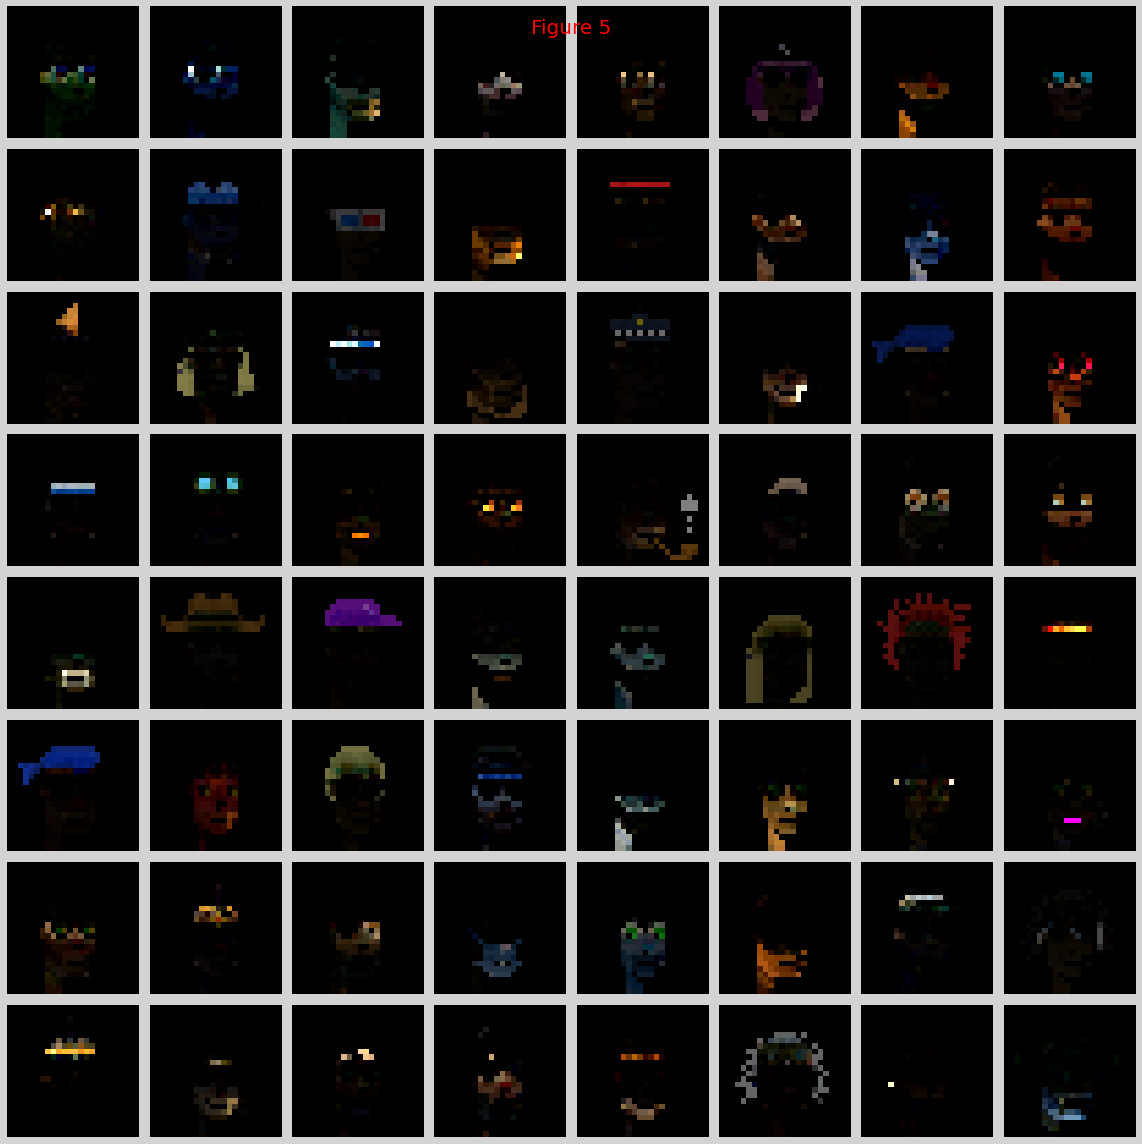

In [117]:
np.random.seed(1)

#Increasing d: 
N = 500
d = 128

choices128 = np.random.choice(faces.shape[-1],N, replace = False)
faces_choice128 = faces[:,:,:,:N]

W128, H128, opacity128, error128 = NMF_N_pictures(faces_choice,N,d)

W_reshaped128 = np.reshape(W128, (24,24,3,d))
W_reshaped128[W_reshaped128 > 1.0] = 1.0

plotimgs(W_reshaped128, title = "Figure 5")


### $\textbf{Reconstruction}$

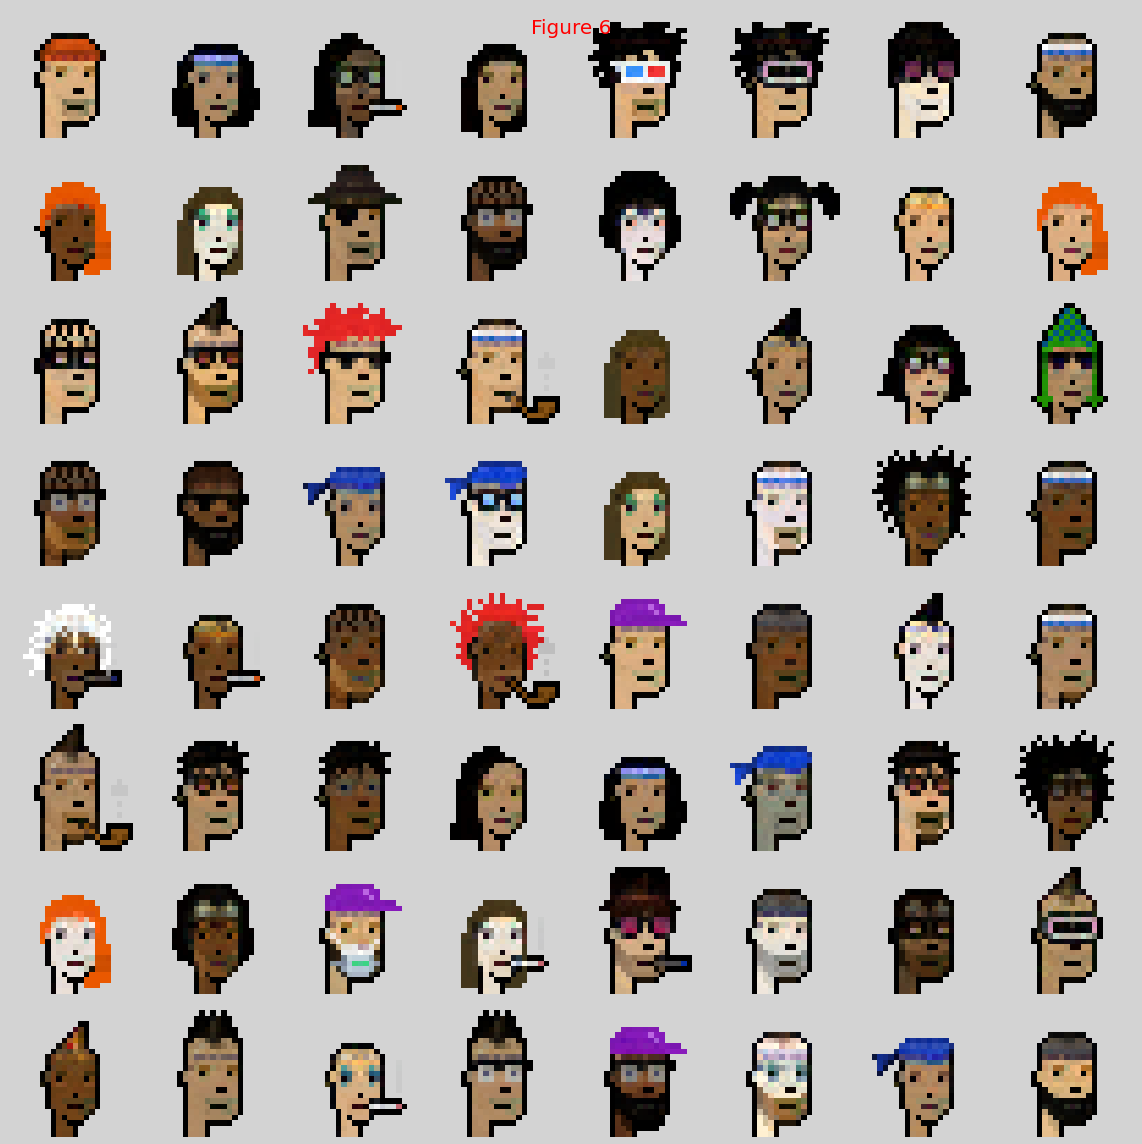

In [118]:
N = 500
d = 64


faces_2d_nmf = reconstruct_picture(W, H, opacity, N=500)

plotimgs(faces_2d_nmf, title = "Figure 6")

In $\textbf{figure 6}$ above we have plotted the reconstructions $WH$ of the image in $\textbf{figure 2}$. The reconstructions are overall good, as we can see that it resembles the original one plotted in figure over. However, there are blurry parts in most of the reconstructed crypto punks. This blurriness appears especially in components that are not that common. For example on the eyewear and the components in the face of an alien.
In contrast, common components are well reconstructed, and for example the black mouth is not blurry for any of the plotted crypto punks.

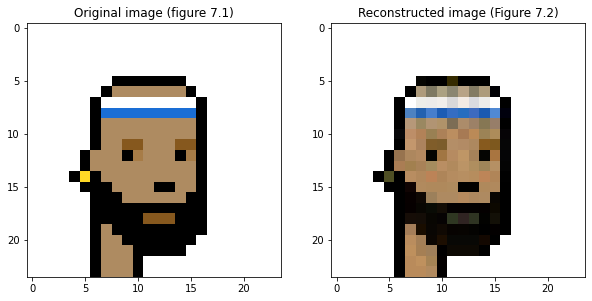

In [47]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(faces[:, :, :, 7])
plt.title("Original image (figure 7.1)")

plt.subplot(1, 2, 2)
plt.imshow(faces_2d_nmf[:, :, :, 7])
plt.title("Reconstructed image (Figure 7.2)")

plt.show()

In $\textbf{figure 7}$ we get a closer look on one of the reconstructed CryptoPunks. This particular example shows how the NMF with $d = 64$ fails to reconstruct the earring. The observant reader will see that this is a problem which manifests itself throughout the entire $\textbf{figure 6}$. Increasing $d$ will resolve the issue. Depending on application, $d = 64$ is probably a too aggressive compression. 

### $\textbf{Error for reconstructions}$

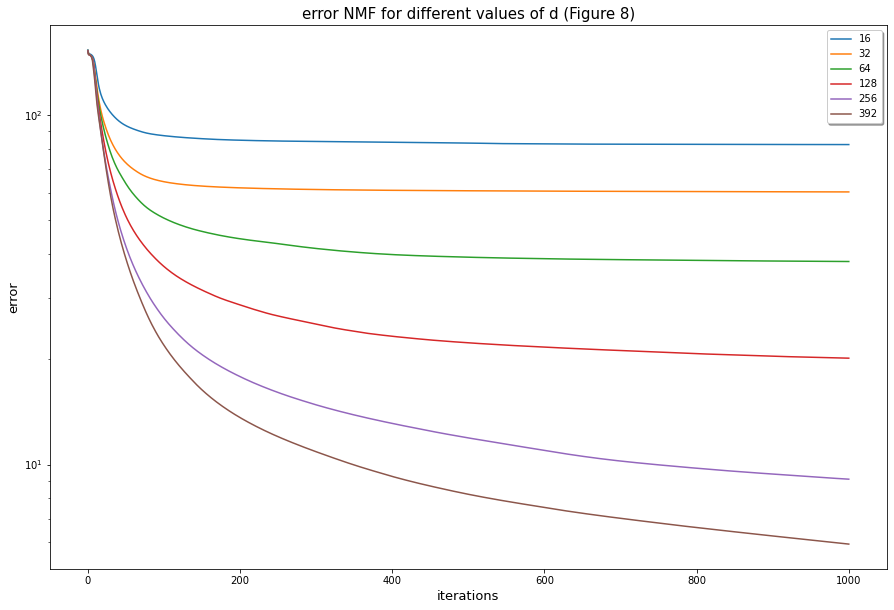

Rank of current dataset: 400


In [119]:
np.random.seed(1)

N = 500

choices = np.random.choice(faces.shape[-1],N, replace = False)
faces_2e = faces[:,:,:,choices]

d_vals = [16,32,64, 128,256, 392]

error_vals = []

k_vals = np.linspace(0,1000, 1000)


plt.figure(figsize = (15,10))
plt.title("error NMF for different values of d (Figure 8)", fontsize = 15)
plt.xlabel("iterations", fontsize = 13)
plt.ylabel("error", fontsize = 13)
plt.yscale('log')

for i in range(len(d_vals)):
    _,_,_,error = NMF_N_pictures(faces_2e,N,d_vals[i])
    plt.plot(k_vals, error,label = str(d_vals[i]))

    error_vals.append(error[-1])

plt.legend(fancybox = True, shadow = True)
plt.show()

e2_reshaped = np.reshape(faces_2e, (24*24*4, 500))
print(f'Rank of current dataset: {np.linalg.matrix_rank(e2_reshaped)}')

$\textbf{Figure 8}$ shows how $||A - W_k H_k||_F$ develops for different values of $d$. It looks like the algorithm has converged towards a local minima as the theory states it will. Which local minima will be dependent on the initial values.
We can see that all the curves flatten out after some iterations, but that the higher the number of columns in W, d, the lower the error measured with the frobenius norm. The result is reasonable because the higher d is, the more information W and H holds. The more information W and H holds there are less reasons there are to use the approximation. One of the key reasons to use NMF is to save space.

To get the desired outcome you have to weigh how much less quality you can tolerate with how much space you want to use, as well as controlling computer resources.

Below in figure $\textbf{figure 9}$ one can see the value of the Frobenius norm for the runs with different values of $d$. We would expect that that norm to decrease with higher d because the higher d makes the algorithm able to capture more features and give an accurate representation. When d is as large as the norm of A the algorithm should in theory be able to give a perfect representation. When we have low d we are not able to capture all the features of the pictures and the representation will be very inaccurate.  We observe from that the norm of the error confirmed our expectations. 

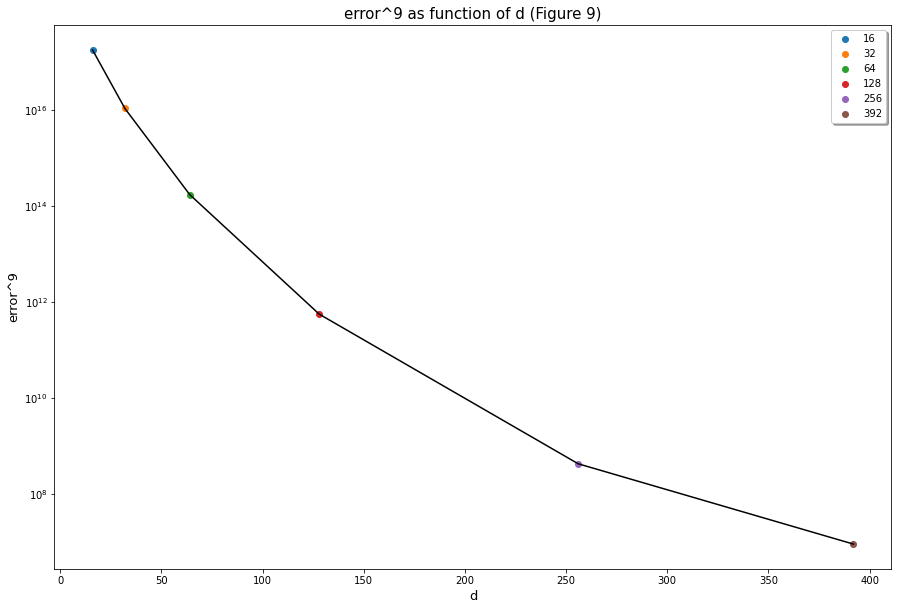

In [120]:
plt.figure(figsize=(15,10))
plt.title("error^9 as function of d (Figure 9)", fontsize = 15)
plt.xlabel('d', fontsize = 13)
plt.ylabel('error^9', fontsize = 13)
plt.yscale('log')

for i in range(len(error_vals)):
    plt.plot(d_vals[i], error_vals[i]**9, 'o', label = str(d_vals[i]))

plt.plot(d_vals, np.array(error_vals)**9, 'black')
plt.legend(fancybox = True, shadow = True)
plt.show()

## $\textbf{6 Denoising}$

We are now moving towards the last part of this project, where NMF will be used to denoise images. Below, noisy images have been created by modifying the pixels in the following way: 

$$
\begin{equation}
A_{noisy} = A + \sigma E
\tag{6}
\end{equation}
$$

Here $\sigma$ is the level of noise and $E$ is a matrix of same shape as $A$ with normal distributed components. The function **add_noise()** will add noise to the images in the same manner as described in **(6)**, and the noisy data will then be pushed through the NMF algorithm. 

Our aim is here to generate the same features from the noisy images as from the original dataset. This makes us able to reconstruct the originals from the contaminated images. 

In [11]:
faces_reshaped = np.reshape(faces[:,:,0:3,:],(1728,10000))

def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces

In [12]:
np.random.seed(1)

#parameters
N = 500
sigma = 0.1

choices = np.random.choice(faces.shape[-1],N, replace = False)
faces_3a = faces[:,:,:,choices]
opacity = faces_3a[:,:,3,:]

faces_3a_reshaped = np.reshape(faces_3a[:,:,0:3,:], (24*24*3,N))

faces_noisy_3a_reshaped = add_noise(faces_3a_reshaped,sigma)

faces_noisy_3a = np.reshape(faces_noisy_3a_reshaped, (24,24,3,N))



### $\textbf{Noisy images}$

Below in $\textbf{figure 10}$ the reader can see the result when noise with $\sigma = 0.1$ is applied to the pictures. The difference between these images and the ones we saw in $\textbf{figure 2}$ is significant. Now the Cryptopunks contain a large amount of discolored pixels. 

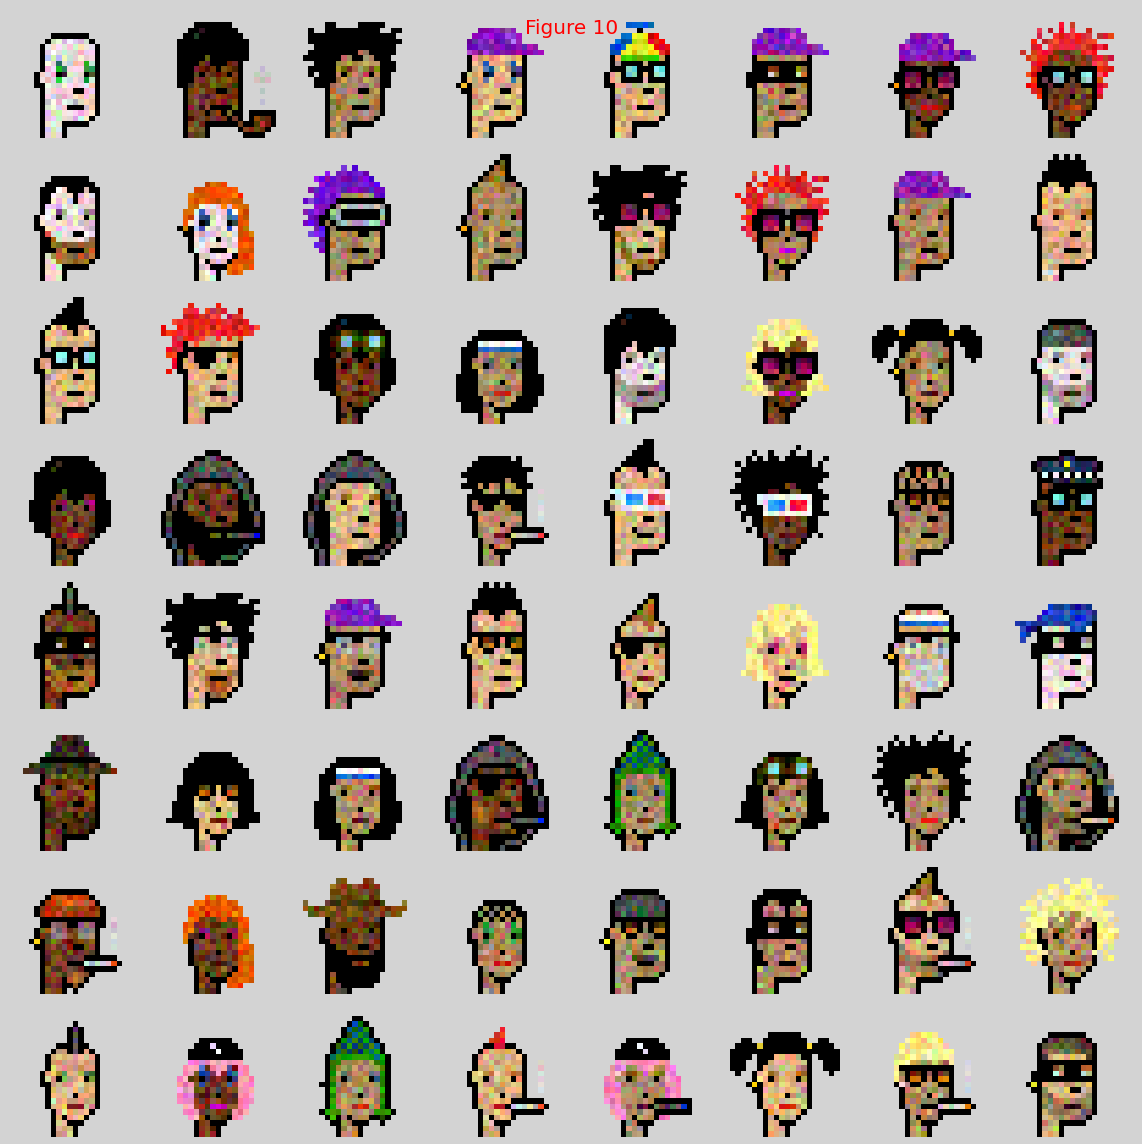

In [13]:
faces_noisy_3a = np.insert(faces_noisy_3a,3,opacity,axis = 2)

plotimgs(faces_noisy_3a, title = "Figure 10")

In [15]:
print(f"The norm between the noisy faces and the normal faces is: {np.linalg.norm(faces_noisy_3a_reshaped - faces_3a_reshaped)}")

The norm between the noisy faces and the normal faces is: 42.00101435186506


The error for these noisy images are as follows: $||A_{noisy} - A||_F = 41.869879$. 

### $\textbf{Applying NMF to noisy images}$

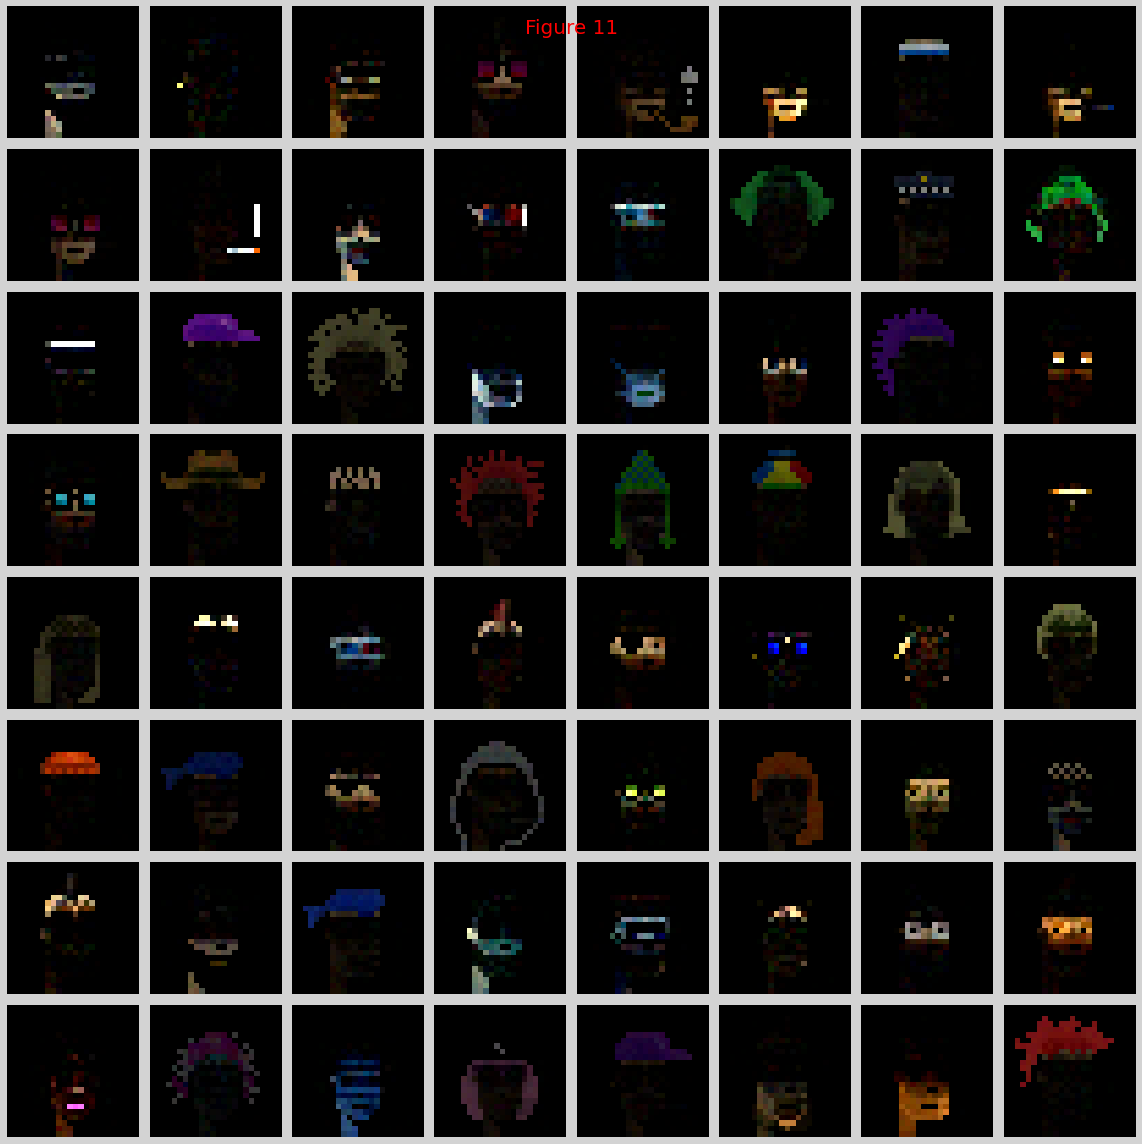

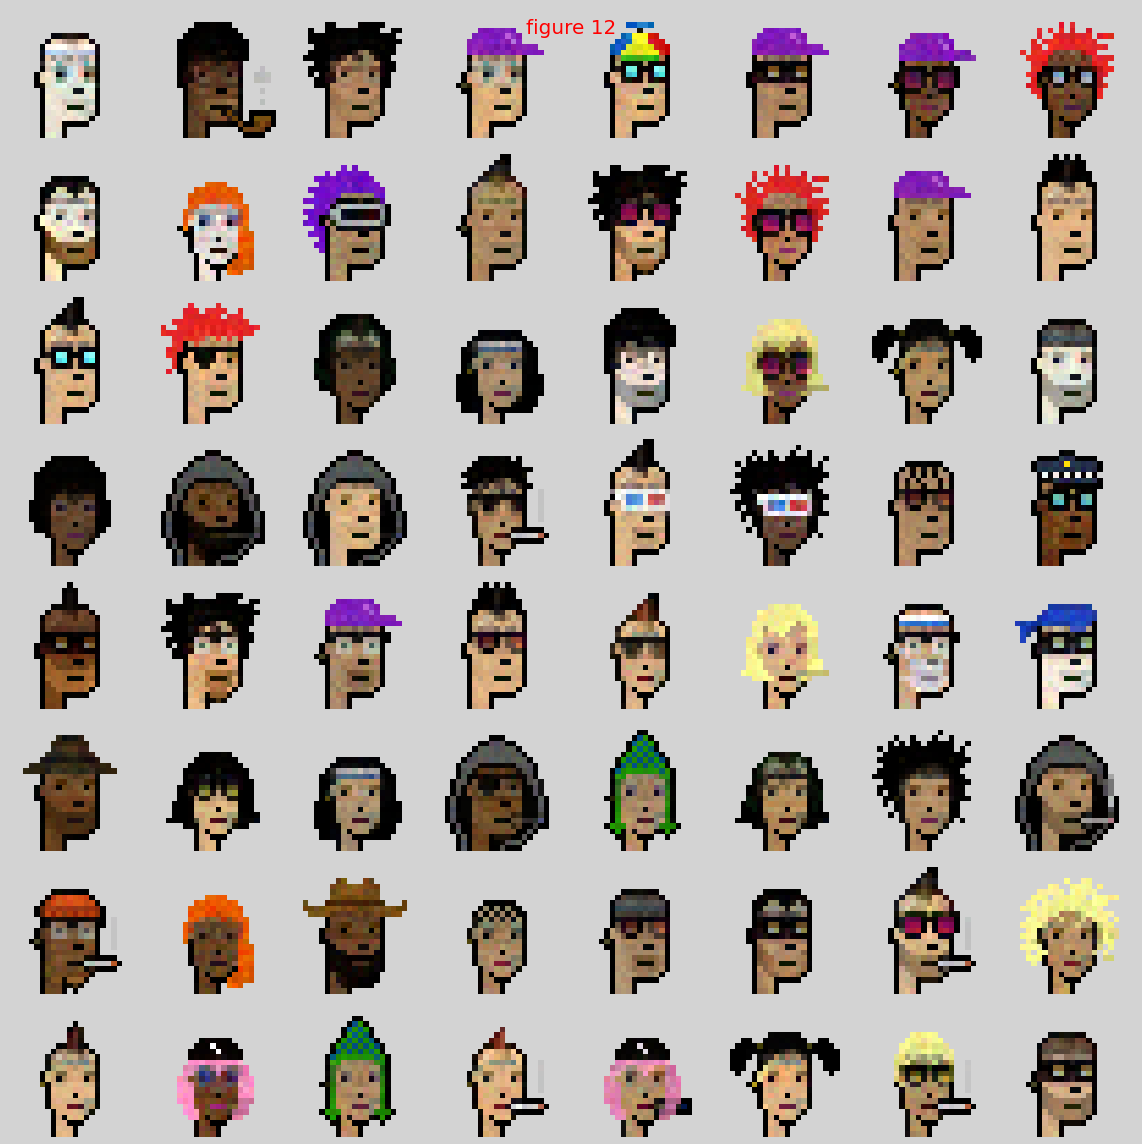

In [14]:
d = 64

W, H, opacity, error = NMF_N_pictures(faces_noisy_3a,N,d)

#plotting columns of W: 
W_noisy_3b = np.reshape(W, (24, 24, 3, d))
W_noisy_3b[W_noisy_3b > 1.0] = 1.0

plotimgs(W_noisy_3b, title = "Figure 11")

#plotting the reconstructed picture
faces_3a_nmf = reconstruct_picture(W,H,opacity,N)

plotimgs(faces_3a_nmf, title = "figure 12")


In $\textbf{figure 11 and 12}$ we observe that we to some extent get the same features even though they are generated from noisy images. Meaning we succeeded in only saving the important features and not capturing the noise. But the features we saved are somewhat contaminated by the noise images they were constructed from. We think it is quite impressive the way we generate nearly the same column room from the contaminated pictures. 

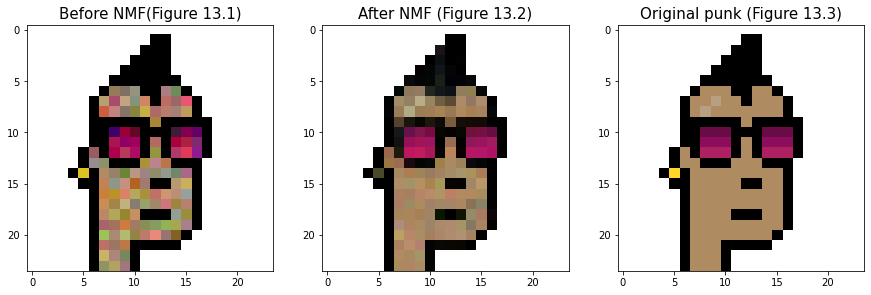

In [103]:
plt.figure(figsize = (15, 15))


plt.subplot(1, 3, 1) 
plt.imshow(faces_noisy_3a[:, :, :, 33])
plt.title("Before NMF(Figure 13.1)", fontsize = 15)

plt.subplot(1, 3, 2)
plt.imshow(faces_3a_nmf[:, :, :, 33])
plt.title("After NMF (Figure 13.2)", fontsize = 15)

plt.subplot(1, 3, 3)
plt.imshow(faces_3a[:, :, :, 33])
plt.title("Original punk (Figure 13.3)", fontsize = 15)

plt.show()

Above $(\textbf{figure 13})$ one can get a closer look on just how impressive the NMF is when denoising the images. Note that $d$ is just $64$, which means that the reconstruction contains significantly fewer datapoints than the noisy images! 

### $\textbf{Finding the optimal d}$

A suitable end to this project is now to find the optimal d for denoising the images in $\textbf{figure 10}$. To do this, we will as usual calculate $||A - WH||_F$, where $A$ is the images before we deploy noise. When doing this, we expect the error to become smaller for larger values of $d$, but we will also see how the $d$ can become too large. 

When finding the optimal d there are two different effects working against each other. As we increase the d we are able to represent more features but we are more prone to overfitting and we incorrectly represent more noise as features. When d decreases we make sure to only get the most important features and hence not include as much noise. But the problem is of course that we risk not representing all the different features in the images. 

In [126]:
d_vals = [32, 64, 128, 150, 160, 180,200, 250, 300]
error_vals = []

for d in d_vals:
    W,H,opacity, error = NMF_N_pictures(faces_noisy_3a,N = 500, d = d)
    error_vals.append(np.linalg.norm(faces_3a_reshaped - W@H, 'fro'))

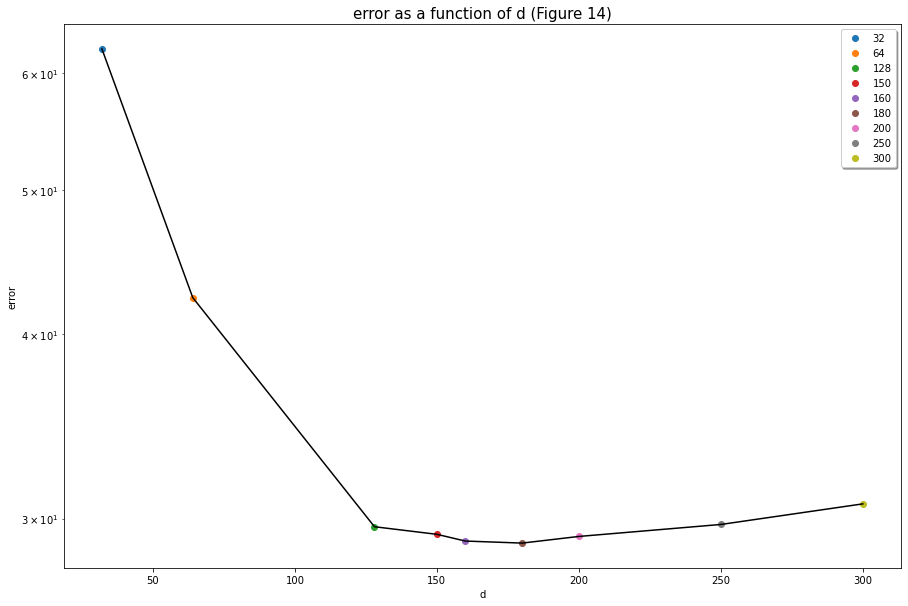

In [127]:
plt.figure(figsize=(15,10))
plt.title('error as a function of d (Figure 14)', fontsize = 15)

for i in range(len(d_vals)):
    plt.plot(d_vals[i], error_vals[i], 'o', label = str(d_vals[i]))

plt.plot(d_vals, error_vals, 'black')
plt.xlabel('d')
plt.ylabel('error')
plt.yscale('log')
plt.legend(fancybox = True, shadow = True)
plt.show()

When plotting the difference in norm we get a U-shaped plot. This is an excelent example of over- and underfitting. The optimal $d$ will be situated on the bottom of this U, and from $\textbf{figure 14}$, it looks like this is between $160$ and $180$. 


Note that this result is connected to $\sigma = 0.1$. If the value of $\sigma$ increases, we would expect the optimal $d$ to be lower than above. This makes sense since there is more noise, and the model will be more prone to incorrectly capture contamination as features. In contrast, the optimal $d$ will be higher as we decrease the value of $\sigma$. Even though we are adding more columns, they will contain less contamination and therefore give a more accurate representation. 

## $\textbf{7 Conclusion}$

In this project, we have applied non-negative matrix factorization on images to reduce the dimensions of the dataset and to remove noise from the images. The algorithm has proved itself to work very well on the given dataset. It is important to note that we only can consider using NMF representation when the images are made up of similar features. When this is the case, the algorithm can perform an effective dimension reduction. 

As we have seen though the latter part of the project, NMF can also be used for reconstruction of contaminated data. In this project it as proven itself to be very impressive, as we saw how applying NMF dramatically decreased noise, especially when choosing a suitable value of $d$. Note that it is quite impressive that we get both a compressed dataset and less contamination. 

However, we must not get carried away. This algorithm will only work if each image can be generated by a linear combination of distinct features. Hence, similar features must be situated in the same place.

When considering denoising, other options are typically AI techniques. However, such approaches will need an enormous quantity of uncontaminated pictures to generate satisfying reconstructions. This will have the advantages of not only being able to represent linear relationships. 

In conclusion, NMF is a powerful tool when dealing with a dataset which can be represented as a linear combination of different features. 
